Causal representation learning (CRL) does not tell us what each latent factors actually mean. In this notebook, we search for a benchmark that is highly correlated with the latent factor, which allows for interpretability.



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Change the directory to the Tables folder
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'
OOD_TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/ood_r2/'
FIG_DIR = '/content/drive/MyDrive/LLM causality/Figures/'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

We look at the latent factor $z_3$, which by definition is some weighted average of the observed benchmark performance. Moreover, the weights are already learned by LiNGCReL.

In [4]:
import os
FIG_DIR_0136 = '/content/drive/MyDrive/LLM causality/Figures/new/Base model subgroups filtered/Normalized/3/model_indices_[0, 1, 3, 6]/'
FIG_DIR_0136_LOGISTIC = FIG_DIR_0136 + 'logistic_fit/'
FIG_DIR_0136_MIXING = FIG_DIR_0136 + 'mixing_matrix/'
mixing_matrix = np.load(FIG_DIR_0136_MIXING + "mixing_matrix.npy")
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']
frequent_base_models_new = ['llama-3-8b', 'llama-3.1-8b', 'qwen2.5-14b',  'qwen2.5-7b']
df_new = pd.read_csv(TABLE_DIR + "open_llm_leaderboard_with_tokens.csv")

# Uncomment the following if working with the old leaderboard
# FIG_DIR_0136 = '/content/drive/MyDrive/LLM causality/Figures/old/Base model subgroups/Normalized/3/model_indices_[0, 1, 2, 4, 5]/'
# FIG_DIR_0136_LOGISTIC = FIG_DIR_0136 + 'logistic_fit/'
# FIG_DIR_0136_MIXING = FIG_DIR_0136 + 'mixing_matrix/'
# cols_to_transform_new = ['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']
# frequent_base_models_new = ['mistral-7b', 'llama-3-8b', 'llama-2-13b', 'llama-2-7b', 'mixtral-8x7b']
# df_new = pd.read_csv(TABLE_DIR + "open_llm_leaderboard_old_with_tokens.csv")

os.makedirs(FIG_DIR_0136_LOGISTIC, exist_ok=True)

We look at the six benchmarks used in the old version of open LLM leaderboard. To allow comparison, we extract. data of the models that appear in both the old version and the new version.

In [5]:
def marge_on_fullname(df_new, cols_to_transform_new = cols_to_transform_new, merge = True):
  df_new['fullname'] = df_new['fullname'].str.lower()

  sub_df = df_new

  for i in range(mixing_matrix.shape[1]):
    weighted_values = sub_df[cols_to_transform_new].mul(mixing_matrix[:,i])
    sum_of_weighted_values = weighted_values.sum(axis=1)
    sub_df['z_' + str(i+1)] = sum_of_weighted_values

  return sub_df

In [6]:
%%capture
sub_df = marge_on_fullname(df_new)

In [7]:
model_counts = df_new['Identified base model'].value_counts()
inv_df = sub_df[sub_df['Identified base model'].str.contains('|'.join(frequent_base_models_new), na = False)]
out_df = {
    key: sub_df[sub_df['Identified base model'].str.contains(key.lower(), na=False)]
    for key in ['Gemma-2-9B', 'Mistral-7B', 'Qwen2.5-0.5B', 'Qwen2.5-3B', 'Llama-2-7B', 'Llama-2-13B', 'Llama-3.2-1B']
}

In [8]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [9]:
plt.rcParams['font.family'] = 'serif'

In [10]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [11]:
def latent_ols(idx, display_ood = False):

  vibrant_colors = ['#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c', '#e74c3c', '#34495e', '#e67e22', '#16a085']

  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.size'] = 12
  plt.rcParams['axes.facecolor'] = '#f8f9fa'
  plt.rcParams['figure.facecolor'] = 'white'
  plt.rcParams['grid.color'] = '#dcdcdc'
  plt.rcParams['grid.linestyle'] = '--'
  plt.rcParams['grid.linewidth'] = 0.5

  r_squared_dict = {}
  opt_coef_dict = {}

  for col in cols_to_transform_new:
      X_ = inv_df[[col] + ['z_' + str(i) for i in range(1, idx)]].values
      X = sm.add_constant(X_)  # Add a constant term to the independent variables
      y = inv_df['z_' + str(idx)].values

      model = sm.OLS(y, X).fit()
      r2 = model.rsquared

      r_squared_dict[col] = {}
      r_squared_dict[col]['In Sample'] = r2  
      coefficients = model.params[1:] 
      opt_coef_dict[col] = model.params

      print(f"R-squared for {col}: {r2:.4f}")
      print(f"Coefficients for {col}: {coefficients}")

      y_predicted = model.fittedvalues
      fig, ax = plt.subplots(figsize=(10, 6))

      ax.set_facecolor('#f8f9fa')
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['left'].set_color('#555555')
      ax.spines['bottom'].set_color('#555555')

      color_index = 0  

      sns.scatterplot(
          x=inv_df[col].values,
          y=(y-np.sum([model.params[i+1]*X_[:,i] for i in range(1, idx)], axis = 0))/coefficients[0],
          label='In-sample data',
          color=vibrant_colors[color_index],
          edgecolors='white',
          linewidth=0.4,
          s=60,
          alpha=0.7
      )
      color_index += 1

      if display_ood:
          for key, value in out_df.items():
              X_out = value[[col] + ['z_' + str(i) for i in range(1, idx)]].values
              X_out = sm.add_constant(X_out)  
              y_out = value['z_' + str(idx)].values \
                - np.sum([model.params[i+1]*value['z_' + str(i)].values for i in range(1, idx)], axis = 0)

              predictions_out = model.predict(X_out)
              # Calculate R-squared for the out-of-sample group
              r2_out_sample = r2_score(value['z_' + str(idx)].values, predictions_out)

              r_squared_dict[col][key] = round(r2_out_sample, 2)

              sns.scatterplot(
                  x=value[col].values,
                  y=y_out/model.params[1],
                  label=key,
                  color=vibrant_colors[color_index],
                  edgecolors='white',
                  linewidth=0.4,
                  s=40,
                  alpha=0.7
              )
              color_index += 1


      plt.plot(
          inv_df[col].values,
          (y_predicted - np.sum([model.params[i+1]*X_[:,i] for i in range(1, idx)], axis = 0))/model.params[1],
          color='#34495e',
          linewidth=2.5,
          label='OLS Fit',
          zorder=10
      )

      plt.text(
          0.05, 0.95,
          'In sample ' + r'$R^2$' + f' = {r2:.2f}',
          transform=plt.gca().transAxes,
          fontsize=20,
          verticalalignment='top',
          bbox=dict(
              boxstyle='round,pad=0.5',
              facecolor='white',
              alpha=0.8,
              edgecolor='#cccccc'
          )
      )

      plt.ylabel("Latent Factor " + r"$z_{" + str(idx) + "}$", fontsize=28, fontweight='bold', color='#333333')
      plt.xlabel(col + " accuracy", fontsize=28, fontweight='bold', color='#333333')
      plt.title(f'OLS Regression Fit for {col}', fontsize=28, fontweight='bold', color='#333333')

      plt.grid(True, alpha=0.3)

      plt.legend(
          fontsize=18,
          frameon=True,
          framealpha=0.9,
          edgecolor='#dddddd',
          fancybox=True,
          loc='best'
      )

      plt.tight_layout()
      plt.savefig(FIG_DIR_0136_LOGISTIC + f"z_{idx}_fit_{col}.pdf", dpi=300, bbox_inches='tight')
      plt.close()

  # Find the column with the maximal in-sample R^2
  max_r2_col = max(r_squared_dict, key=lambda k: r_squared_dict[k]['In Sample'])

  print("max_r2_col = ", max_r2_col)

  max_r2_data = r_squared_dict[max_r2_col]
  df = pd.DataFrame([max_r2_data])

  df['latent'] = 'z_' + str(idx)
  os.makedirs(OOD_TABLE_DIR, exist_ok=True)
  # Define the output file path
  output_file_path = os.path.join(OOD_TABLE_DIR, "latent_regression_ood.csv")

  if os.path.exists(output_file_path):
      df.to_csv(output_file_path, mode='a', header=False, index=False)
  else:
      df.to_csv(output_file_path, index=False)


  # Get the optimal coefficients
  max_coef = opt_coef_dict[max_r2_col]

  print(max_r2_col, max_coef)
  return max_coef

In [12]:
WEIGHT_DIR = FIG_DIR_0136 + 'causal_weights/'
import os
import numpy as np

def load_npy_files_to_dict(directory):
  """Loads all .npy files from a directory into a dictionary.

  Args:
    directory: The path to the directory containing the .npy files.

  Returns:
    A dictionary where keys are filenames (without extension) and values
    are the loaded NumPy arrays.
  """

  npy_files = [f for f in os.listdir(directory) if f.endswith('.npy')]
  data_dict = {}
  for file in npy_files:
    filename = os.path.splitext(file)[0]  # Get filename without extension
    filepath = os.path.join(directory, file)
    data_dict[filename] = np.load(filepath)
  return data_dict

weight_data = load_npy_files_to_dict(WEIGHT_DIR)

In [13]:
transformed_mixing = np.zeros_like(mixing_matrix.T)
cons_list = []
for idx in range(1, 4):
  max_coef = latent_ols(idx)
  print(max_coef)
  coef = (mixing_matrix[:,idx-1] - np.sum([mixing_matrix[:,i] * max_coef[i+2] for i in range(len(max_coef)-2)], axis=0)) / max_coef[1]
  transformed_mixing[idx-1] = coef

  for filename, weight in weight_data.items():
    weight[idx-1] = (weight[idx-1] - np.sum([weight[i] * max_coef[i+2] for i in range(len(max_coef)-2)], axis=0)) / max_coef[1]

  cons = max_coef[0] / max_coef[1]
  cons_list.append(cons)

R-squared for IFEval: 0.1412
Coefficients for IFEval: [-0.35987136]
R-squared for BBH: 0.9413
Coefficients for BBH: [-1.57181332]
R-squared for MATH Lvl 5: 0.6432
Coefficients for MATH Lvl 5: [-0.89298522]
R-squared for GPQA: 0.7888
Coefficients for GPQA: [-3.01743495]
R-squared for MUSR: 0.6094
Coefficients for MUSR: [-2.3572606]
R-squared for MMLU-PRO: 0.9451
Coefficients for MMLU-PRO: [-1.62221112]
max_r2_col =  MMLU-PRO
MMLU-PRO [ 4.83907134 -1.62221112]
[ 4.83907134 -1.62221112]
R-squared for IFEval: 0.8984
Coefficients for IFEval: [ 0.82388887 -0.37757904]
R-squared for BBH: 0.4017
Coefficients for BBH: [ 0.74886894 -0.25245534]
R-squared for MATH Lvl 5: 0.6169
Coefficients for MATH Lvl 5: [0.99092075 0.01286231]
R-squared for GPQA: 0.4673
Coefficients for GPQA: [-2.27706951 -1.29620788]
R-squared for MUSR: 0.4805
Coefficients for MUSR: [-1.61295942 -1.11793535]
R-squared for MMLU-PRO: 0.4253
Coefficients for MMLU-PRO: [1.46335743 0.15162746]
max_r2_col =  IFEval
IFEval [-12.2333

In [14]:
for filename, weight in weight_data.items():
  weight = np.linalg.inv(weight)
  for i in range(weight.shape[0]):
    weight[i] = weight[i] / weight[i,i]

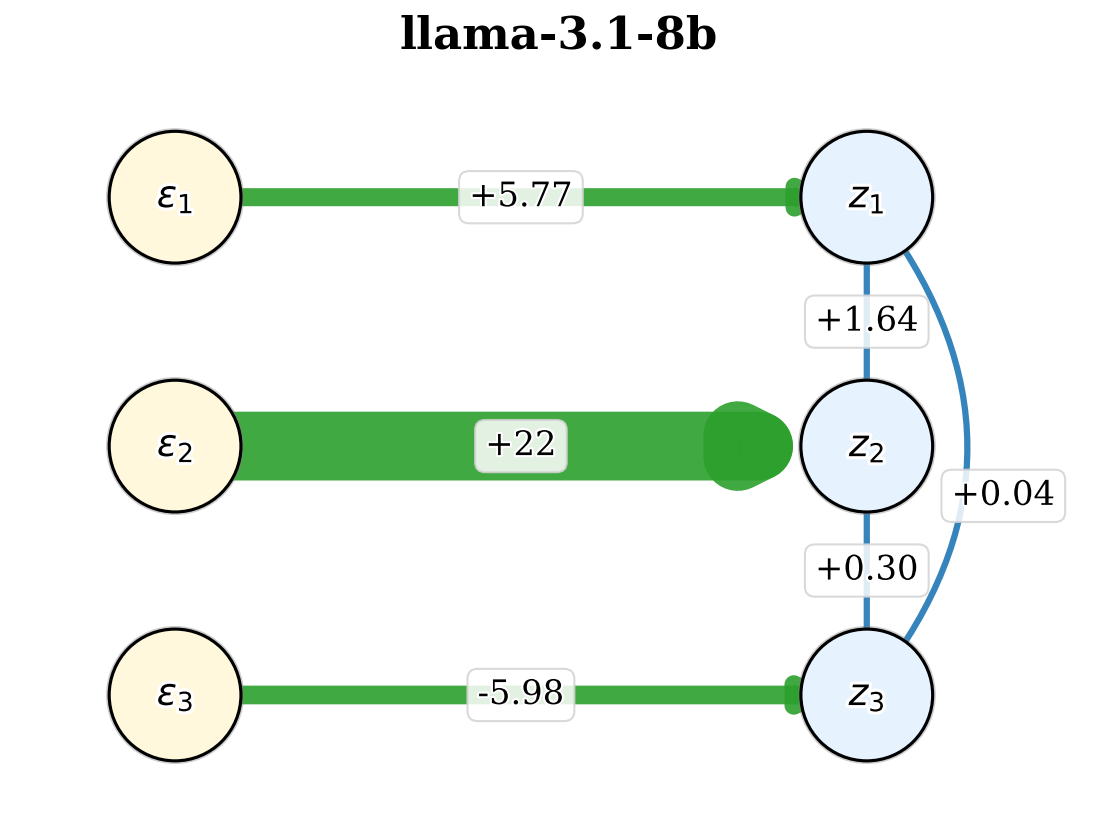

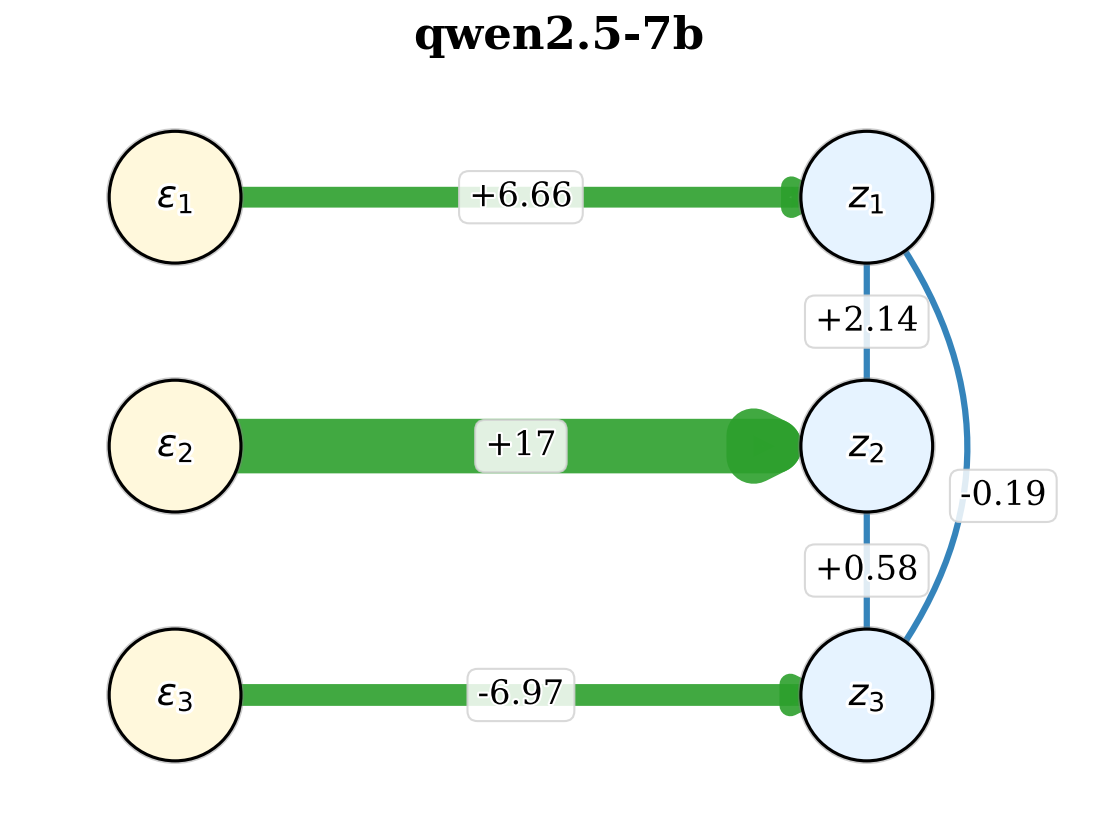

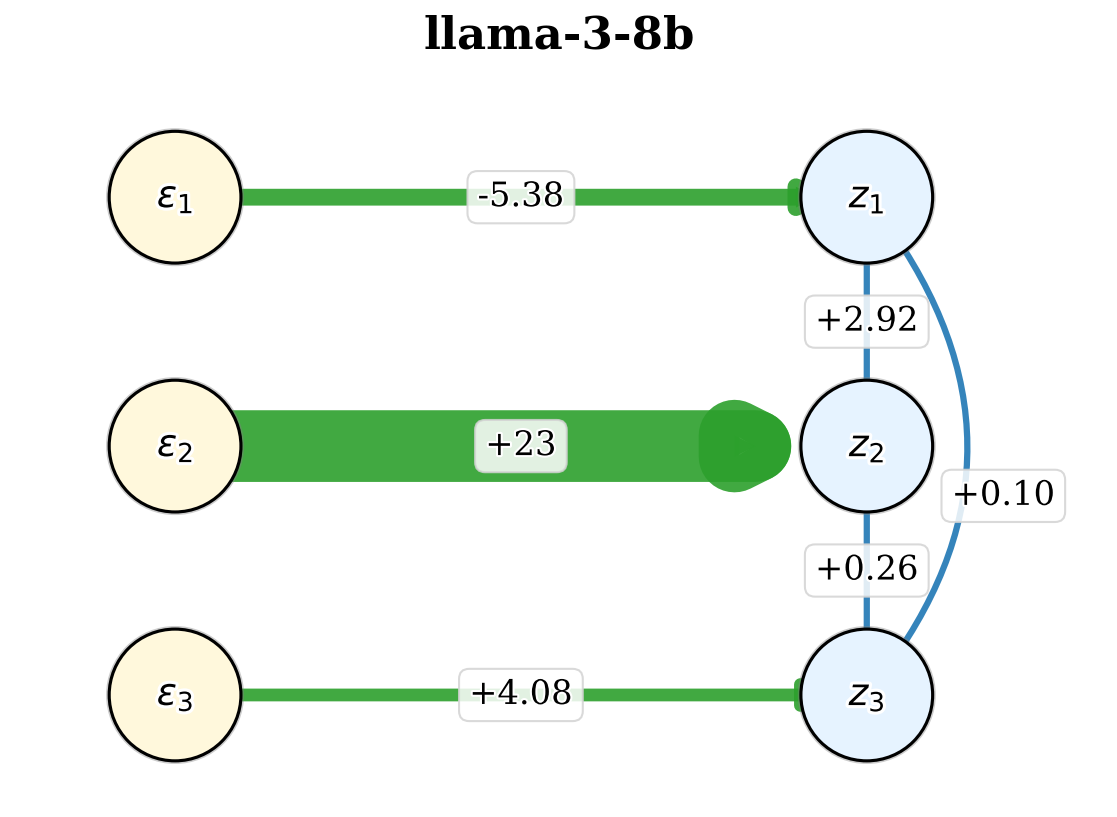

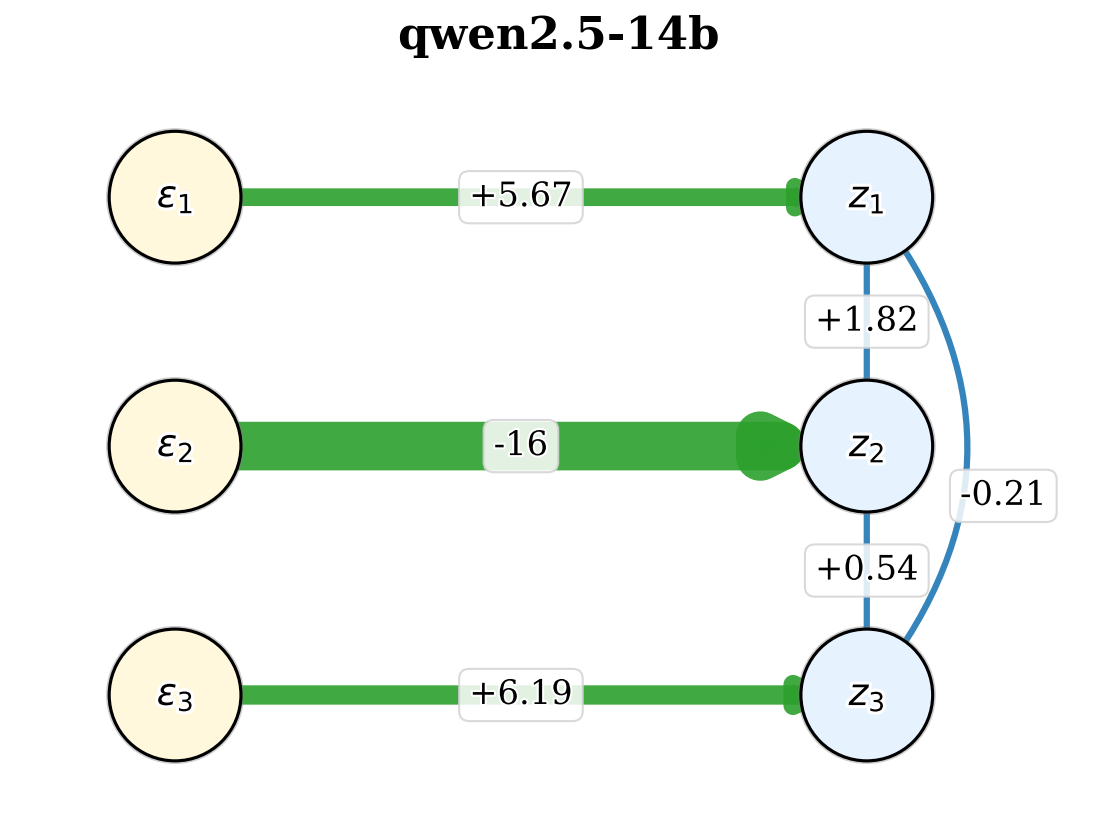

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patheffects as pe

# ----------------------------------------------------------------------
# Helper: recover A (strictly lower‑triangular) and b from a L‑triangular B
# z = B ε   ⟺   z_i = Σ_{j<i} a_{ij} z_j + b_i ε_i
# ----------------------------------------------------------------------
def structural_coeffs_from_B(B: np.ndarray):
    """
    Parameters
    ----------
    B : (d,d) array_like, lower‑triangular with non‑zero diagonal.
        This matrix represents the overall linear transformation from ε to z, i.e., z = B ε.

    Returns
    -------
    A : (d,d) ndarray
        Strictly lower‑triangular matrix of coefficients a_ij for z_j -> z_i dependencies.
    b : (d,)  ndarray
        Vector of coefficients b_i for ε_i -> z_i dependencies.
    """
    B = np.asarray(B, dtype=float)
    if B.shape[0] != B.shape[1] or not np.allclose(B, np.tril(B)):
        raise ValueError("B must be square & lower‑triangular.")
    if np.any(np.isclose(np.diag(B), 0)):
        raise ValueError("Diagonal of B must be non‑zero.")

    b_coeffs = np.diag(B).copy()

    A_coeffs = np.eye(len(B)) - np.diag(b_coeffs) @ np.linalg.inv(B)
    A_coeffs[np.triu_indices_from(A_coeffs)] = 0.0
    return A_coeffs, b_coeffs


def visualize_structural_model(
        B_matrix: np.ndarray,
        title: str = "",
        figsize: tuple = (8, 6),
        font_size: int = 18,
        node_size: int = 4000,
        node_edge_lw: float = 1.5,
        edge_width_scale: float = 3,
        arrow_size: int = 25,
        label_font_size_scale: float = 0.9,
        edge_label_bbox_pad: float = 0.2,
        edge_label_pos_default: float = 0.5,
        curved_edge_label_offset: float = 0.15,
        eps_node_color: str = "#fff8dc",       # Cornsilk
        z_node_color: str = "#e6f3ff",         # Light blue
        eps_z_edge_color: str = "#2ca02c",     # Green
        z_z_edge_color: str = "#1f77b4",       # Blue
        edge_alpha: float = 0.9,
        curved_edge_rad: float = 0.4,
        use_enhanced_label_positioning: bool = True,
        label_bg_alpha: float = 0.85,
        use_path_effects: bool = True,
        dpi: int = 150
):
    """
    Draw the DAG for  z_i = Σ_{j<i} a_{ij} z_j + b_i ε_i.
    The coefficients a_ij and b_i are derived from the input B_matrix (where z = B_matrix ε).

    * ε_i -> z_i : green horizontal arrows, weight b_i
    * z_j -> z_i : blue; curved if j<i-1 (e.g. z1->z3), weight a_ij

    Parameters
    ----------
    B_matrix : (d,d) lower‑triangular ndarray from z = B_matrix ε.
    title : Title for the plot.
    figsize : Size of the matplotlib Figure.
    font_size : Base font size for node labels.
    node_size : Matplotlib node size.
    node_edge_lw : Linewidth for node borders.
    edge_width_scale : Multiplies |coeff| to set line thickness.
    arrow_size : Size of arrowheads on edges.
    label_font_size_scale : Scale factor for edge label font size.
    edge_label_bbox_pad : Padding for the bbox around edge labels.
    edge_label_pos_default : Default position of labels along edges (0=source, 1=target).
    curved_edge_label_offset : Offset for labels on curved z-to-z edges.
    eps_node_color : Color for epsilon nodes.
    z_node_color : Color for z nodes.
    eps_z_edge_color : Color for epsilon->z edges.
    z_z_edge_color : Color for z->z edges.
    edge_alpha : Transparency for edges.
    curved_edge_rad : Curvature parameter for non-adjacent z->z edges.
    use_enhanced_label_positioning : Whether to use custom positioning for edge labels.
    label_bg_alpha : Alpha transparency for label backgrounds.
    use_path_effects : Whether to add outline effects to text for better visibility.
    dpi : DPI for the figure.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": font_size,
        "figure.dpi": dpi,
        "text.usetex": False  
    })

    A_coeffs, b_coeffs = structural_coeffs_from_B(B_matrix)
    d = len(B_matrix)

    eps_labels = [fr"$\varepsilon_{{{i+1}}}$" for i in range(d)]
    z_labels   = [fr"$z_{{{i+1}}}$" for i in range(d)]

    G = nx.DiGraph()
    G.add_nodes_from(eps_labels + z_labels)

    edge_lbl, edge_col, edge_wid, edge_shape, edge_pos = {}, {}, {}, {}, {}

    custom_label_positions = {}

    for i in range(d):
        u, v = eps_labels[i], z_labels[i]
        coeff = b_coeffs[i]
        if np.isclose(coeff, 0) and coeff != 0:  
            continue
        G.add_edge(u, v)
        edge_lbl[(u, v)] = f"{coeff:+.2f}" if abs(coeff) < 10 else f"{coeff:+.2g}"
        edge_col[(u, v)] = eps_z_edge_color
        edge_wid[(u, v)] = max(0.6, edge_width_scale * abs(coeff) / 2)
        edge_shape[(u, v)] = "arc3,rad=0.0"
        edge_pos[(u, v)] = edge_label_pos_default

    for i in range(d):
        for j in range(i):
            coeff = A_coeffs[i, j]
            if np.isclose(coeff, 0) and coeff != 0:
                continue
            u, v = z_labels[j], z_labels[i]
            rad = 0.0 if i == j + 1 else curved_edge_rad * (-1 if j % 2 == 0 else 1)
            G.add_edge(u, v)
            edge_lbl[(u, v)] = f"{coeff:+.2f}" if abs(coeff) < 10 else f"{coeff:+.2g}"
            edge_col[(u, v)] = z_z_edge_color
            edge_wid[(u, v)] = max(0.6, edge_width_scale)
            edge_shape[(u, v)] = f"arc3,rad={rad}"

            if i - j > 1:  
                curve_side = "right" if rad < 0 else "left"
                gap = i - j  

                if curve_side == "left":
                    edge_pos[(u, v)] = 0.5 - 0.05 * gap
                    if j == 0 and i == 2:  
                        edge_pos[(u, v)] = 0.35 
                else:
                    edge_pos[(u, v)] = 0.5 + 0.05 * gap

                custom_label_positions[(u, v)] = edge_pos[(u, v)]
            else:
                edge_pos[(u, v)] = edge_label_pos_default

    x_left, x_right = 0.12, 0.88
    y_coords = np.linspace(0.95, 0.05, d) if d > 1 else np.array([0.5])

    pos = {eps_labels[k]: (x_left, y_coords[k]) for k in range(d)}
    pos.update({z_labels[k]: (x_right, y_coords[k]) for k in range(d)})

    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    node_colors = [eps_node_color] * d + [z_node_color] * d

    nodes = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, node_color=node_colors,
        edgecolors="black", linewidths=node_edge_lw, ax=ax
    )

    if use_path_effects:
        nodes.set_path_effects([
            pe.withStroke(linewidth=3, foreground='gray', alpha=0.4)
        ])

    for (u, v) in G.edges():
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            edge_color=edge_col[(u, v)], alpha=edge_alpha,
            width=edge_wid[(u, v)],
            arrows=True,
            arrowstyle="-|>",
            arrowsize=arrow_size,
            connectionstyle=edge_shape[(u, v)],
            ax=ax,
            min_source_margin=15,
            min_target_margin=15
        )

    edge_label_font_size = font_size * label_font_size_scale

    bbox_props = dict(
        boxstyle="round,pad=0.3",
        facecolor="white",
        edgecolor="lightgray",
        alpha=label_bg_alpha,
    )

    if use_enhanced_label_positioning:
        for edge, label_text in edge_lbl.items():
            u, v = edge
            x1, y1 = pos[u]
            x2, y2 = pos[v]

            pos_along_edge = edge_pos.get(edge, edge_label_pos_default)

            special_offset_x, special_offset_y = 0, 0

            if u in z_labels and v in z_labels:
                j = z_labels.index(u)
                i = z_labels.index(v)
                if i - j > 1:  
                    rad_val = curved_edge_rad * (-1 if j % 2 == 0 else 1)

                    if j == 0 and i == 2:  
                        if rad_val > 0:  
                            special_offset_x = -curved_edge_label_offset
                            special_offset_y = 0
                        else:  
                            special_offset_x = curved_edge_label_offset
                            special_offset_y = 0
                    else:
                        if rad_val > 0: 
                            special_offset_x = -curved_edge_label_offset
                        else: 
                            special_offset_x = curved_edge_label_offset

            x = x1 + pos_along_edge * (x2 - x1) + special_offset_x
            y = y1 + pos_along_edge * (y2 - y1) + special_offset_y

            text = ax.text(
                x, y, label_text,
                size=edge_label_font_size,
                ha='center', va='center',
                bbox=bbox_props,
                zorder=5  
            )

            if use_path_effects:
                text.set_path_effects([
                    pe.withStroke(linewidth=2, foreground='white')
                ])
    else:
        drawn_edge_labels = nx.draw_networkx_edge_labels(
            G, pos, edge_labels=edge_lbl,
            font_size=edge_label_font_size,
            label_pos=0.5,  
            bbox=bbox_props,
            ax=ax,
            rotate=False
        )

    node_labels = nx.draw_networkx_labels(
        G, pos,
        font_size=font_size,
        font_family="serif",
        font_weight="bold",
        ax=ax
    )

    if use_path_effects:
        for _, text in node_labels.items():
            text.set_path_effects([
                pe.withStroke(linewidth=3, foreground='white')
            ])

    ax.set_axis_off()
    if title:
        ax.set_title(title, pad=20, fontsize=font_size * 1.2, fontweight='bold')

    ax.margins(x=0.15, y=0.15) 
    fig.tight_layout(pad=1.5)

    return fig, ax




for filename, weight in weight_data.items():
    fig, ax = visualize_structural_model(weight, filename[0:-8])
    plt.savefig(WEIGHT_DIR + filename + '.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
np.save(FIG_DIR_0136_LOGISTIC + 'transformed_unmixing.npy', transformed_mixing)

In [17]:
transformed_unmixing = np.load(FIG_DIR_0136_LOGISTIC + 'transformed_unmixing.npy')

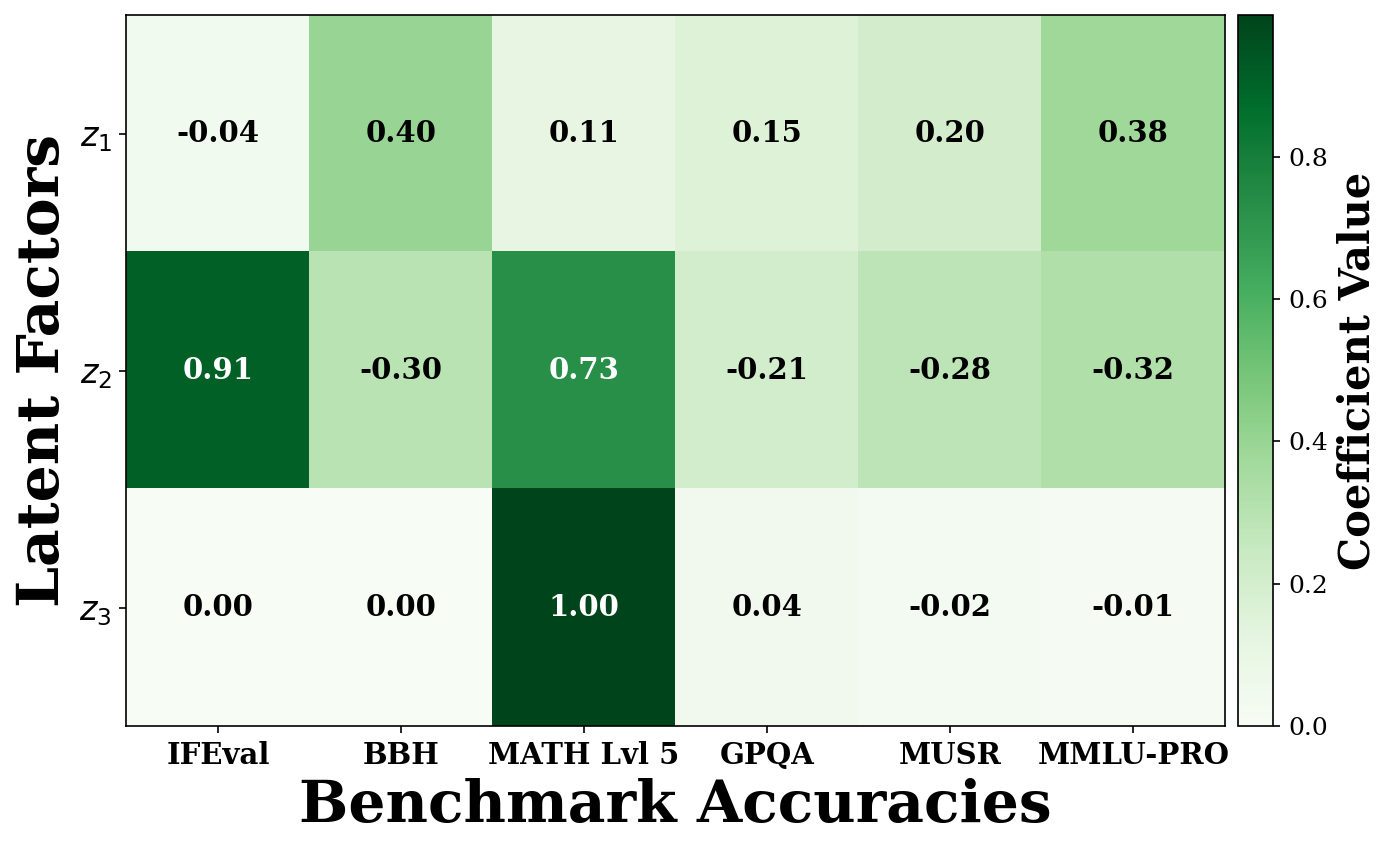

In [18]:
from matplotlib.colors import FuncNorm
fig_M_opt, ax_M_opt = plt.subplots(figsize=(10, 6)) 
ax_M_opt.set_xticks([])
ax_M_opt.set_yticks([])
abs_max = np.abs(transformed_unmixing).max()
norm = FuncNorm((np.abs, lambda x: x), vmin=0, vmax=abs_max)
im = ax_M_opt.imshow(transformed_unmixing, cmap='Greens', norm=norm, aspect='auto')

x_labels = cols_to_transform_new
ax_M_opt.set_xticks(np.arange(len(x_labels)))
ax_M_opt.set_xticklabels(x_labels, fontsize=14, fontweight='bold')

y_labels = ['$z_1$', '$z_2$', '$z_3$']
ax_M_opt.set_yticks(np.arange(len(y_labels)))
ax_M_opt.set_yticklabels(y_labels, fontsize=16, fontweight='bold')

cbar = fig_M_opt.colorbar(im, ax=ax_M_opt, pad=0.01)
cbar.ax.set_ylabel('Coefficient Value', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

ax_M_opt.set_xlabel("Benchmark Accuracies", fontsize=28, fontweight='bold')
ax_M_opt.set_ylabel("Latent Factors", fontsize=28, fontweight='bold')

for (j, k), value in np.ndenumerate(transformed_unmixing.T):
    color = "black" if abs(value) < abs_max * 0.7 else "white"
    ax_M_opt.text(j, k, f'{value:.2f}', ha='center', va='center',
                color=color, fontsize=14, fontweight='bold')

fig_M_opt.tight_layout()
plt.savefig(FIG_DIR_0136_LOGISTIC + "transformed_unmixing_matrix.pdf", dpi=300, bbox_inches='tight')
plt.show()